In [11]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata 
!pip install git+https://github.com/theislab/scgen.git
!pip install matplotlib
!pip install scanpy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Colab_Notebooks/perturbation_metric_test'
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/theislab/scgen.git to /tmp/pip-req-build-6wmv__pz
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/scgen.git /tmp/pip-req-build-6wmv__pz
  Resolved https://github.com/theislab/scgen.git to commit 06084773e56cad0dec340138441dee47a39af752
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [12]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np
import torch
import torch.nn.functional as F

font = {'family' : 'Arial',
        'size'   : 14}
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
train.layers['counts'] = train.X.copy()
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=10, subset=True)
train.X = train.layers['counts']

from scvi import settings

def log_zinb_positive(
    x: torch.Tensor, mu: torch.Tensor, theta: torch.Tensor, pi: torch.Tensor, eps=1e-8
):
    """Log likelihood (scalar) of a minibatch according to a zinb model.
    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res

from typing import Union
import jax.numpy as jnp

def log_nb_positive(
    x: Union[torch.Tensor, jnp.ndarray],
    mu: Union[torch.Tensor, jnp.ndarray],
    theta: Union[torch.Tensor, jnp.ndarray],
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
):
    """Log likelihood (scalar) of a minibatch according to a nb model.
    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res

In [20]:
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

import matplotlib.pyplot as plt
import statsmodels.api as sm 
from joblib import Parallel,delayed
import torch
import torch.nn.functional as F
def data_prep(adata,conditions=None,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    control = adata[adata.obs["perturbation"] == conditions["x"]]
    stim = adata[adata.obs["perturbation"] == conditions["y"]]
    
    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])
    
    x,_ = sample_obs(control,n)
    y,_ = sample_obs(stim,n)
        
    x=x.toarray()
    y=y.toarray() 
    
    return x,y

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y

def sample_obs(adata,size_n):
    """
    params 
    -------------
    sample for all control and stim pairs 
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]

import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n].toarray()
    sample2=x[index_dict['1'],:size_n].toarray()
    sample3=x[index_dict['2'],:size_n].toarray() 
    
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
    return pairs 

def process_item_alpha(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        # model=sm.NegativeBinomialP(x[i],one).fit()
        model=ZeroInflatedNegativeBinomialP(x[i],one).fit() 
        if model.params[2]>0:
            # print(model.summary())
            return model.params[2]
        else:
            return None 
    
def process_item_const(i,x):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        # model=sm.NegativeBinomialP(x[i],one).fit()
        model=ZeroInflatedNegativeBinomialP(x[i],one).fit() 
        if model.params[2]>0:
        # print(model.summary())
            return model.params[1]
        else:
            return None 

def process_per_batch(x,num_from,num_to):
    x=x[num_from:num_to,:]

    alpha=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_alpha)(i,x)for i in range(x.shape[0])
    )

    const=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_const)(i,x)for i in range(x.shape[0])
    ) 
    return alpha,const    


In [22]:
def test_get_data(zinb,train,metric_str):
    """
    fn: the function to get datasets after sampling before we fit the gene in sample1 and sample2
    
    """
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    conditions={"x":"control","y":"stim"}
    difference=[]
    if_stim=['stim']*len(list_stim)
    # sample1 is always sampled from control and sample2 is sampled from 99 different stim 
    #use prep_data to sample respectively 
     
    for stim in list_stim:
        conditions["y"]=str(stim)
        # print(conditions)
        out=zinb(train,conditions,str(stim))
        print("data:",out)
        difference.append(out)
    
    #lastly,for (ctrl,ctrl) where we apply a different sampling method, get three points 
    conditions["y"]="control"
    control = train[train.obs["perturbation"] == conditions["x"]]
    print(conditions)
    pairs=sample_control_control(control,control.shape[0])
     
    for i in range(3):
        (x,y)=pairs[i]
        out=zinb(adata=train,conditions=conditions,stim_str='control'+str(i),sample_ctrl=True,ctrl1=x,ctrl2=y)
        print(" data for (contrl, control):",out)
        difference.append(out)

    zero=['control']*3
    if_stim=if_stim + zero
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric  

def compute_log_zinb(x,const_x,alpha_x):
    mu=np.exp(const_x)
    theta=1/alpha_x
    # p=1/(1+theta)*mu
    p=mu*theta/(1+theta)
    nan=0
    if 1-p<=0 or p<=0:
      most_frequent=0
      nan+=1
    else:
      logit=np.log((1-p)/p)
      x_val=log_zinb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))
      # x_val=log_nb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta))
      most_frequent=torch.mode(x_val).values.item()
    return most_frequent,nan 

def zinb_fit_ctrl(adata, conditions,stim_str,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99)

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i])
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 

differece0,if_stim0,metric0=test_get_data(zinb_fit_ctrl,train,'zinb')

genegene 0 1

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.238738
         Iterations: 20
         Function evaluations: 23Optimization terminated successfully.

         Current function value: 0.366388         Gradient evaluations: 23
         Iterations: 21

gene         Function evaluations: 23
         Gradient evaluations: 23 
4
gene 6
Optimization terminated successfully.
         Current function value: 0.126990
         Iterations: 24Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 27
         Current function value: 0.315583         Gradient evaluations: 27
         Iterations: 35
         Function evaluations: 37

         Gradient evaluations: 37gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene7
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: 0.549637
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.1831469

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.238738
         Iterations: 20Optimization terminated successfully.

         Function evaluations: 23
         Gradient evaluations: 23         Current function value: 0.366388
         Iterations: 21

         Function evaluations: 23
         Gradient evaluations: 23
genegene  64

         Current function value: 0.315583
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.126990
         Iterations: 24 
         Function evaluations: 275

         Gradient evaluations: 27
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.549637
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 8
Optimization terminated successfully.
         Current function value: 0.183146
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006418460522278716
gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.206397
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.
         Gradient evaluations: 28
         Current function value: 0.106404gene
          Iterations: 244

         Function evaluations: 28
         Gradient evaluations: 28
gene 6
Optimization terminated successfully.
         Current function value: 0.144516
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 5
Optimization terminated successfully.
         Current function value: 0.202841
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.602575
gene         Iterations: 35 
7         Function evaluations: 38
         Gradient evaluations: 38

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
gene 9
Optimization terminated successfully.
         Current function value: 0.173129
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.206397
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.
         Gradient evaluations: 28
         Current function value: 0.106404
gene         Iterations: 24 
4         Function evaluations: 28
         Gradient evaluations: 28

gene 6
Optimization terminated successfully.
         Current function value: 0.144516Optimization terminated successfully.

         Current function value: 0.202841
         Iterations: 22
         Iterations: 24         Function evaluations: 25

         Gradient evaluations: 25         Function evaluations: 27

gene         Gradient evaluations: 27 
7
genegene 8
 5
Optimization terminated successfully.
         Current function valu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005470020918437512
gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.128029
         Iterations: 25
         Function evaluations: 28
         Current function value: 0.392665

gene          Iterations: 35
4         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.306444
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
5
         Current function value: 0.356759
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
         Current function value: 0.337981
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.227674
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.128029
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
4
         Current function value: 0.392665
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.306444
         Iterations: 25
         Function evaluations: 28 
6         Gradient evaluations: 28

gene 5
         Current function value: 0.356759
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
         Current function value: 0.337981
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
         Current function value: 0.227674
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00032875246779440204
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.055538
         Iterations: 18

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.021407
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.271336
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.315784
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.120091
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.596548
         Iterations: 35
         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.026349
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.055538
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


2
Optimization terminated successfully.
         Current function value: 0.021407
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan         Iterations: 22

         Iterations: 1         Function evaluations: 25

         Function evaluations: 112         Gradient evaluations: 25

         Gradient evaluations: 112
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6
Optimization terminated successfully.
         Current function value: 0.120091
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
gene Warning: Maximum number of iterations has been exceeded.7

         Current function value: 0.315784
gene          Iterations: 35
         Function evaluations: 378
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: 0.596548
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.026349
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
data: -0.0006696738136838576
gene gene 0
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.190312
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.
         Current function value: 0.262264
         Iterations: 23Optimization terminated successfully.

         Function evaluations: 25
         Current function value: 0.327825         Gradient evaluations: 25

         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene         Function evaluations: 25
          Gradient evaluations: 256

gene 5
Optimization terminated successfully.
         Current function value: 0.105026
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.433198gene
         Iterations: 19
         Function evaluations: 22 7
         Gradient evaluations: 22

gene 8
gene 9
Optimization terminated successfully.
         Current function value: 0.176806
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene gene 10
gene
 2
gene 3
Optimization terminated successfully.
         Current function value: 0.190312
         Iterations: 23
         Function evaluations: 26
Optimization terminated successfully.
         Gradient evaluations: 26         Current function value: 0.262264

         Iterations: 23gene
         Function evaluations: 25 
4         Gradient evaluations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Current function value: 0.327825
         Iterations: 22
         Function evaluations: 25
Optimization terminated successfully.         Gradient evaluations: 25

         Current function value: 0.105026
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
genegene  75

gene 8
Optimization terminated successfully.
         Current function value: 0.433198
Optimization terminated successfully.         Iterations: 19

         Current function value: 0.176806         Function evaluations: 22
         Gradient evaluations: 22

         Iterations: 21
gene          Function evaluations: 249
         Gradient evaluations: 24

data: -0.00025155218008876545
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.109382

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 19
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 24
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: nan 
3         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.353710
         Iterations: 23Optimization terminated successfully.

         Function evaluations: 26
         Current function value: 0.376782         Gradient evaluations: 26
         Iterations: 19

         Function evaluations: 22gene
 6
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.567124
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.245173
         Iterations: 35
         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 38         Current function value: nan

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112gene
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.055697
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.109382

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.353710


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.
         Current function value: 0.376782

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 19gene
          Function evaluations: 225

         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.567124


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 35
         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.055697
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.9

         Current function value: 0.245173
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007934224227938103
genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.328627


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 28
gene 3
Optimization terminated successfully.
         Current function value: 0.309048
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 6
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.185468

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 25
         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan7

gene 8         Iterations: 1

         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.616440
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2Optimization terminated successfully.

         Current function value: 0.328627
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

Optimization terminated successfully.
         Current function value: 0.309048
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Current function value: 0.185468         Gradient evaluations: 112

         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 5
         Gradient evaluations: 25
gene 7
Optimization terminated successfully.gene 8

         Current function value: 0.616440

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 18


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0009788408588065067
gene 0gene 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.119395
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 4

         Current function value: 0.398252         Current function value: 0.215173

         Iterations: 23         Iterations: 35

         Function evaluations: 27         Function evaluations: 38

         Gradient evaluations: 27         Gradient evaluations: 38



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 5
Optimization terminated successfully.
         Current function value: 0.101297
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
gene 7Warning: Maximum number of iterations has been exceeded.
gene
          Current function value: 0.611038
8
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.156432


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 25
         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
geneOptimization terminated successfully.
          Current function value: 0.119395
3         Iterations: 21

         Function evaluations: 25
         Gradient evaluations: 25
gene 4
Optimization terminated successfully.
         Current function value: 0.215173
         Iterations: 23
         Function evaluations: 27Warning: Maximum number of iterations has been exceeded.
         Gradient evaluations: 27

         Current function value: 0.398252
gene 6
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.101297
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
gene 7
gene 8
         Current function value: 0.611038
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.156432
         Iterations: 25
         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Gradient evaluations: 289



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006403189030000552
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.120590
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 27
         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 3
Optimization terminated successfully.
         Current function value: 0.301703
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
5         Current function value: 0.395512

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.562346
         Iterations: 35         Function evaluations: 37

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.213708
         Iterations: 21
         Function evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.087091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Current function value: 0.035873         Iterations: 1

         Iterations: 19         Function evaluations: 112
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.120590

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.301703
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.395512

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
5
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.562346
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 37

         Gradient evaluations: 37
         Current function value: 0.213708

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 21
          Function evaluations: 23
7         Gradient evaluations: 23

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.087091
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 9
Optimization terminated successfully.
         Current function value: 0.035873
         Iterations: 19
         Function evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005314455253634757
gene gene 0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed,

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanWarning: Desired error not necessarily achieved due to precision loss.
         Iterations: 1

         Current function value: nan
         Function evaluations: 112         Iterations: 1
         Gradient evaluations: 112

         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflo

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.284524
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.277153


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Gradient evaluations: 38         Current function value: nan
         Iterations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 112
gene         Gradient evaluations: 112
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.531397

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.         Current function value: nan

         Current function value: 0.219966         Iterations: 1
         Iterations: 26

         Function evaluations: 112         Function evaluations: 29

         Gradient evaluations: 112
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 1gene
          Function evaluations: 1122

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.284524
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
         Current function value: 0.277153
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.531397

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 21 
6         Function evaluations: 23

         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.219966
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006180099881021306
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.097824
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.
         Current function value: 0.032669
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
         Function evaluations: 112
gene         Gradient evaluations: 112 
3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.357422
         Iterations: 24
         Function evaluations: 27Optimization terminated successfully.

         Gradient evaluations: 27         Current function value: 0.395919

         Iterations: 21gene
         Function evaluations: 24
          Gradient evaluations: 245

gene 6
Optimization terminated successfully.
         Current function value: 0.147279
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
 7
         Current function value: 0.602827


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.147279
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.097824

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 24
         Function evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
Optimization terminated successfully.
         Current function value: 0.032669
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.357422gene
          Iterations: 244

         Function evaluations: 27
         Gradient evaluations: 27
gene 5
Optimization terminated successfully.
         Current function value: 0.395919
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 6
Optimization terminated successfully.
         Current function value: 0.147279Warning: Maximum number of iterations has been exceeded.

         Iterations: 21         Current function value: 0.602827

         Function evaluations: 25         Iterations: 35

         Gradient evaluations: 25         Function evaluations: 37

         Gradient evaluations: 37gene
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.147279
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008014295491799809
gene 0
gene 1
gene 2
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.114135

         Iterations: 26         Current function value: 0.048679

         Function evaluations: 30         Iterations: 22
         Gradient evaluations: 30
         Function evaluations: 28
         Gradient evaluations: 28

gene gene3
 4
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.184217
         Current function value: 0.328212         Iterations: 20
         Function evaluations: 23

         Gradient evaluations: 23
         Iterations: 22gene
          Function evaluations: 24
6         Gradient evaluations: 24

gene 5
Optimization terminated successfully.
         Current function value: 0.158089
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
          Current function value: 0.6849517

gene         Iter

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.150438
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 0gene 
1
gene 2
Optimization terminated successfully.
         Current function value: 0.114135
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.048679
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28
gene Optimization terminated successfully.
         Current function value: 0.1842174

         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.328212
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene 5

         Current function value: 0.158089
    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.9

         Current function value: 0.150438
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
data: -0.00110280906793984
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.126753

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.342562
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene Warning: Desired error not necessarily achieved due to precision loss.4

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 5

         Current function value: 0.228141
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 6
Optimization terminated successfully.
         Current function value: 0.443792
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.115637
         Iterations: 24
gene         Function evaluations: 27
         Gradient evaluations: 27 
7
genegene  98

Optimization terminated successfully.
         Current function value: 0.224642
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.126753


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 25
         Function evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 3
Optimization terminated successfully.
         Current function value: 0.342562
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.
         Current function value: 0.228141

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.443792
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
geneOptimization terminated successfully.
          Current function value: 0.1156377
gene
         Iterations: 24
          Function evaluations: 278

         Gradient evaluations: 27
gene 9
Optimization terminated successfully.
         Current function value: 0.224642
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
data: -0.0002622315637381689
gene 0
gene 1
gene 2
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.048414
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

Optimization terminated successfully.
         Current function value: 0.431259
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.331446         Current function value: nan

         Iterations: 23         Iterations: 1

         Function evaluations: 112         Function evaluations: 26

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  65

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.492786         Current function value: 0.185763

         Iterations: 22
         Iterations: 21         Function evaluations: 24
         Function evaluations: 24

         Gradient evaluations: 24         Gradient evaluations: 24

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 8
 7
gene 9
Optimization terminated successfully.
         Current function value: 0.154700
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0gene
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.048414

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 17

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 3
Optimization terminated successfully.
         Current function value: 0.431259
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Function evaluations: 112
         Current function value: 0.331446         Gradient evaluations: 112
         Iterations: 23

         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 26gene
 gene6
 5
Optimization terminated successfully.
         Current function value: 0.185763Optimization terminated successfully.
         Iterations: 21

         Current function value: 0.492786
         Function evaluations: 24         Iterations: 22

         Function evaluations: 24         Gradient evaluations: 24

         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 7
genegene  9
8
Optimization terminated successfully.
         Current function value: 0.154700
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
data: -0.0005283178556775662
gene 0
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.239260
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.277655


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 15

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nangene 
         Iterations: 15
         Function evaluations: 112
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.396046
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 41

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 41

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -




         Current function value: 0.239260         Iterations: 23
         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 4
Optimization terminated successfully.
         Current function value: 0.277655
         Iterations: 15
         Function evaluations: 19
         Gradient evaluations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.396046

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7         Current function value: nan

gene         Iterations: 1 
9         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005409868123630682
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.214316

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 21
         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 25
gene 3
         Current function value: 0.387291
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1gene
 4         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.424793
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27Optimization terminated successfully.

gene         Current function value: 0.180050
         Gradient evaluations: 25         Iterations: 22
         Function evaluations: 25

 5gene 7

gene 8
Optimization terminated successfully.
         Current function value: 0.366555
         Iterations: 22
         Function evaluations: 24
Optimization terminated successfully.
         Gradient evaluations: 24
         Current function value: 0.195981
         Function evaluations: 24         Iterations: 21gene
 9

         Gradient evaluations: 24
genegene  1
0gene 
2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.214316

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 25
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.387291
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.424793


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 25gene
          Function evaluations: 276

         Gradient evaluations: 27
gene 5
Optimization terminated successfully.
         Current function value: 0.180050
         Iterations: 22
         Function evaluations: 25
Optimization terminated successfully.
         Gradient evaluations: 25         Current function value: 0.366555

gene         Iterations: 22 
         Function evaluations: 24
         Gradient evaluations: 24
7gene
 gene8 
9
Optimization terminated successfully.
         Current function value: 0.195981
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
data: -0.00041928353311959654
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.090377
         Iterations: 23
         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.404149
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.         Current function value: nan

         Current function value: 0.286483         Iterations: 1
         Iterations: 24
         Function evaluations: 112

         Function evaluations: 26         Gradient evaluations: 112

         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  56

Optimization terminated successfully.
         Current function value: 0.210324
         Iterations: 20
         Function evaluations: 23Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 23         Current function value: 0.406626

         Iterations: 35gene 
         Function evaluations: 377

         Gradient evaluations: 37
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
Optimization terminated successfully.
         Current function value: 0.078299
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1
gene 2
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.090377
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

Optimization terminated successfully.
         Current function value: 0.404149
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.286483

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Current function value: nan
         Gradient evaluations: 26         Iterations: 1

gene         Function evaluations: 112 
5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.         Current function value: 0.406626

         Current function value: 0.210324         Iterations: 35

         Iterations: 20         Function evaluations: 37

         Function evaluations: 23
         Gradient evaluations: 37
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 7 
8gene
 9
Optimization terminated successfully.
         Current function value: 0.078299
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
data: -0.0002819150538092193
gene 0
Optimization terminated successfully.
gene         Current function value: 0.124813
 1         Iterations: 23
gene
         Function evaluations: 26
          Gradient evaluations: 262

gene 3
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.326058

         Iterations: 21         Current function value: 0.067404

         Function evaluations: 23         Iterations: 23

         Gradient evaluations: 23         Function evaluations: 27

         Gradient evaluations: 27gene
 4
gene 6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.285454

         Current function value: 0.122539         Iterations: 23

         Iterations: 24         Func

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.146732
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.058957
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene gene0 1

gene 2
Optimization terminated successfully.
         Current function value: 0.124813
         Iterations: 23Optimization terminated successfully.

         Function evaluations: 26         Current function value: 0.067404

         Gradient evaluations: 26         Iterations: 23

         Function evaluations: 27
gene         Gradient evaluations: 27 3

gene 4
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.326058         Current function value: 0.285454

         Iterations: 21         Iterations: 23

         Function evaluations: 23         Function evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.054580
         Iterations: 19
Optimization terminated successfully.
         Function evaluations: 23
         Gradient evaluations: 23
         Current function value: 0.146732gene 
9
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.058957
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
data: -0.0003243417946166005
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.058304

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.192831


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 25Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 25         Current function value: nan



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 1gene
          Function evaluations: 1124
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.279603
         Iterations: 24
         Function evaluations: 26

         Current function value: 0.509368gene
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
6 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.194731
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.058304
         Iterations: 22
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.192831
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.279603
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
         Current function value: 0.509368gene
 6
         Iterations: 35         Function evaluations: 38

         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.194731

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005178589217393892
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.128634
         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 3
Optimization terminated successfully.
         Current function value: 0.316827
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.274281

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.509775

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 8
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.152688

         Current function value: 0.149311         Iterations: 20

         Iterations: 14
         Function evaluations: 24         Function evaluations: 20
         Gradient evaluations: 24

         Gradient evaluations: 20
gene 7
gene 9
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.128634
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

Optimization terminated successfully.
         Current function value: 0.316827
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.274281
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Function evaluations: 25         Gradient evaluations: 112

         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5
gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.152688

         Iterations: 20
         Current function value: 0.509775         Function evaluations: 24

         Iterations: 35
         Function evaluations: 37         Gradient evaluations: 24

         Gradient evaluations: 37gene
 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8
gene 9
Optimization terminated successfully.
         Current function value: 0.149311
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 20
data: -0.00037437604366156546
genegene 0 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

Optimization terminated successfully.
         Current function value: 0.199188
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




         Iterations: 24
         Function evaluations: 27         Current function value: nan

         Gradient evaluations: 27
         Iterations: 1
gene         Function evaluations: 112 5

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.460482
         Iterations: 22
         Function evaluations: 24
Optimization terminated successfully.
         Gradient evaluations: 24         Current function value: 0.168215



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 23
gene         Function evaluations: 26 
8         Gradient evaluations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 
1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.199188
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.         Current function value: nan

         Current function value: 0.238586         Iterations: 1

         Iterations: 24         Function evaluations: 112

         Function evaluations: 27         Gradient evaluations: 112

         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene5 
6
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.460482

         Current function value: 0.168215         Iterations: 22

         Iterations: 23         Function evaluations: 24

         Function evaluations: 26         Gradient evaluations: 24

         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



genegene  87

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid valu

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003095151032539434
gene gene0 
1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.116787
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.gene 
4
         Current function value: 0.338031
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.
         Current function value: 0.326082
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 5
Optimization terminated successfully.
         Current function value: 0.093901
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.434691

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.192344
         Iterations: 22
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 112         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/stats

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
geneOptimization terminated successfully. 
         Current function value: 0.116787
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
1
gene 2
genegene 3 
4
Optimization terminated successfully.
         Current function value: 0.338031Optimization terminated successfully.

         Current function value: 0.326082
         Iterations: 20         Iterations: 21

         Function evaluations: 23
         Gradient evaluations: 23         Function evaluations: 24

         Gradient evaluations: 24gene 
6
gene 5
Optimization terminated successfully.
         Current function value: 0.093901
         Iterations: 24

         Current function value: 0.434691         Gradient evaluations: 28

gene          Iterations: 357

         Function evaluations: 43

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 43

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.192344
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00037416592310061486
gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.065830
gene         Iterations: 19
         Function evaluations: 24 
         Gradient evaluations: 24
2gene
 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.316772

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.221181
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.461269gene
 6
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.gene
          Current function value: 0.0867919
         Iterations: 24

         Function evaluations: 28
         Gradient evaluations: 28
gene 7
gene 0
gene 1
geneOptimization terminated successfully. 
2
         Current function value: 0.065830
         Iterations: 19
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.316772
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.221181Warning: Desired error not necessarily achieved due to precision loss.

         Iterations: 19         Current function value: nan

         Function evaluations: 22         Iterations: 1

         Gradient evaluations: 22
         Function evaluations: 112
gene         Gradient evaluations: 112 
5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.461269Optimization terminated successfully.

         Iterations: 35         Current function value: 0.086791

         Function evaluations: 37         Iterations: 24

         Gradient evaluations: 37         Function evaluations: 28

         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene gene 87
gene
 9
data: -0.00044934581046618405
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.132751
         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Current function value: 0.320927
         Iterations: 35

         Function evaluations: 112         Function evaluations: 37
         Gradient evaluations: 37

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  45

Optimization terminated successfully.
         Current function value: 0.310646
         Iterations: 24
         Function evaluations: 26
Optimization terminated successfully.         Gradient evaluations: 26

gene         Current function value: 0.341892 
         Iterations: 22
6
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.128479
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene Optimization terminated successfully.
9         Current function value: 0.151154

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.132751
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.320927

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 37gene 
4
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.310646
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.341892
         Iterations: 22
         Function evaluations: 26Optimization terminated successfully.

         Current function value: 0.128479         Gradient evaluations: 26

         Iterations: 23
gene         Function evaluations: 26 
7         Gradient evaluations: 26

genegene 9 
8
Optimization terminated successfully.
         Current function value: 0.151154
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
data: -0.00017419722462364007
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.070019
         Iterations: 17
         Function evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 21
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

Optimization terminated successfully.
         Current function value: 0.328840
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.429658

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 23Warning: Desired error not necessarily achieved due to precision loss.
         Function evaluations: 25

         Current function value: nan         Gradient evaluations: 25

gene 5
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.449947
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37
geneOptimization terminated successfully. 
8         Current function value: 0.133772

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.
         Current function value: 0.097171
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
geneOptimization terminated successfully. 
9
         Current function value: 0.037875
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.070019

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 17


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.328840
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4
Optimization terminated successfully.
         Current function value: 0.429658
         Iterations: 23
         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.449947
         Iterations: 34         Function evaluations: 37


         Gradient evaluations: 37genegene  8
6
Optimization terminated successfully.
         Current function value: 0.097171
Optimization terminated successfully.         Iterations: 24

         Function evaluations: 28         Current function value: 0.133772

         Iterations: 24         Gradient evaluations: 28

         Function evaluations: 27gene
          Gradient evaluations: 279

gene 7
Optimization terminated successfully.
         Current function value: 0.037875
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
data: -0.000356170341415155
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.103412
         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3
Optimization terminated successfully.
         Current function value: 0.496671
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.309858         Gradient evaluations: 112

         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 25 
6
gene 5
Optimization terminated successfully.
         Current function value: 0.131957
Optimization terminated successfully.         Iterations: 22

         Current function value: 0.455358
         Iterations: 22
         Function evaluations: 25         Function evaluations: 24

         Gradient evaluations: 25         Gradient evaluations: 24

genegene  87

Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.040921
         Current function value: 0.117745

         Iterations: 20         Iterations: 17

         Function evaluations: 25         Function evaluations: 22

         Gradient evaluations: 25         Gradient evaluations: 22

gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.103412
         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 3
Optimization terminated successfully.
         Current function value: 0.496671
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.309858
gene         Iterations: 22 
6         Function evaluations: 25

         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.131957
         Iterations: 22Optimization terminated successfully.

         Function evaluations: 25         Current function value: 0.455358

         Gradient evaluations: 25         Iterations: 22

         Function evaluations: 24
gene         Gradient evaluations: 24
 7
gene 8
Optimization terminated successfully.
         Current function value: 0.040921
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
gene 9
         Current function value: 0.117745


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003876619196643917
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.120920

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 23
         Gradient evaluations: 23
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 1 
3         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.680997

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Current function value: 0.694466


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 37
         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 1
gene         Function evaluations: 112
         Gradient evaluations: 112 6



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.161977

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 18


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 22
         Gradient evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene 1
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.120920


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4         Current function value: 0.680997

         Iterations: 35
         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: 0.694466
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nanOptimization terminated successfully.

         Iterations: 1         Current function value: 0.161977

         Function evaluations: 112         Iterations: 18

         Gradient evaluations: 112         Function evaluations: 22



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene7 
8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan         Iterations: 1

         Iterations: 1         Function evaluations: 112

         Function evaluations: 112         Gradient evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
data: -0.003958945650992973
gene 0gene
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.197159
         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 3
Optimization terminated successfully.
         Current function value: 0.247179
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Warning: Maximum number of iterations has been exceeded.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.565612
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 37 6

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.163656
         Iterations: 23
         Function evaluations: 27Optimization terminated successfully.
         Gradient evaluations: 27

         Current function value: 0.469188
         Iterations: 19
         Function evaluations: 21
gene         Gradient evaluations: 21
 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.058687

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.197159

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 23
         Gradient evaluations: 23
gene 3
Optimization terminated successfully.
         Current function value: 0.247179
         Iterations: 22
         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene         Current function value: nan 4

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.565612 
6         Iterations: 35

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5Optimization terminated successfully.

         Current function value: 0.163656
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
gene         Current function value: 0.469188 
7         Iterations: 19

         Function evaluations: 21
         Gradient evaluations: 21
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.058687

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007309717500921428
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.096892
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.338225
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
Optimization terminated successfully.
         Current function value: 0.364897
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
gene         Current function value: 0.133503
         Iterations: 24 
         Function evaluations: 27
5         Gradient evaluations: 27

gene 7
gene 8
         Current function value: 0.395961Optimization terminated successfully.

         Current function value: 0.183689         Iterations: 35

         Function evaluations: 37         Iterations: 21

         Gradien

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.096892
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.338225
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.364897
gene          Iterations: 216

         Function evaluations: 23
         Gradient evaluations: 23
gene 5
Optimization terminated successfully.
         Current function value: 0.133503
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
         Current function value: 0.395961
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.183689


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
9         Iterations: 21

         Function evaluations: 24
         Gradient evaluations: 24
data: -0.0002762393532975693
gene 0
gene 1
gene 2gene
 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.320554
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.395963
         Iterations: 22
         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.328157
         Gradient evaluations: 112
         Iterations: 19


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 23gene
 6
gene 8
Optimization terminated successfully.
         Current function value: 0.173803
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24Optimization terminated successfully.
         Current function value: 0.154767
         Iterations: 25

         Function evaluations: 28
gene         Gradient evaluations: 28
 gene7 
9
gene 0
gene gene1 
gene 2
3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.320554

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 4
Optimization terminated successfully.
         Current function value: 0.395963
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 25
         Gradient evaluations: 25
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Gradient evaluations: 112         Current function value: 0.328157
         Iterations: 19
         Function evaluations: 23

         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 6gene 
8
Optimization terminated successfully.
         Current function value: 0.173803
Optimization terminated successfully.
         Current function value: 0.154767
         Iterations: 25         Iterations: 21

         Function evaluations: 28         Function evaluations: 24

         Gradient evaluations: 24         Gradient evaluations: 28

genegene  9
7
data: -0.00023482133328798228
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.086481


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 27
         Function evaluations: 31


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 31

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 3
Optimization terminated successfully.
         Current function value: 0.194697
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.264676

         Iterations: 21 6
         Function evaluations: 24
         Gradient evaluations: 24
gene 5
Optimization terminated successfully.
         Current function value: 0.125915
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27Warning: Maximum number of iterations has been exceeded.

gene         Current function value: 0.457742 
         Iterations: 35
7
         Function evaluations: 38

gene         Gradient evaluations: 38 8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.086481

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 31

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 31


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.194697
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Current function value: 0.264676         Iterations: 1

         Function evaluations: 112         Iterations: 21

         Gradient evaluations: 112         Function evaluations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6
gene 5
Optimization terminated successfully.
         Current function value: 0.125915
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.457742

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0002616090982883179
gene gene 01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.084241


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 30
gene 3
         Current function value: 0.260710
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Function evaluations: 112         Current function value: 0.270367
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 25
gene          Gradient evaluations: 256

gene 5
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.150256

         Iterations: 22         Current function value: 0.470096
         Function evaluations: 25
         Gradient evaluations: 25

         Iterations: 20
         Function evaluations: 22gene
 7         Gradient evaluations: 22

gene gene 8
9
Optimization terminated successfully.
         Current function value: 0.159620
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 0gene
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.084241
         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 30
         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.260710
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.270367 6
         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.150256
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 7Optimization terminated successfully.         Current function value: 0.470096


         Iterations: 20
gene 
8         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.159620
         Iterations: 26
         Function evaluations: 29

         Gradient evaluations: 29data: -0.00026661348798976786
genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.150495
         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.325283

         Iterations: 35         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.339712gene 
6         Iterations: 24

         Function evaluations: 27
         Gradient evaluations: 27
gene 5
Optimization terminated successfully.
         Current function value: 0.170219
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 7
gene 8Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.404910
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.123456gene
         Iterations: 24 
         Function evaluations: 279

         Gradient evaluations: 27
genegene  01

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.150495
         Iterations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 24
         Gradient evaluations: 24
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.325283
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.
         Current function value: 0.339712

         Gradient evaluations: 112         Iterations: 24

         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 27
gene gene6 
5
Optimization terminated successfully.
         Current function value: 0.170219
         Iterations: 21Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 24         Current function value: 0.404910

         Gradient evaluations: 24         Iterations: 35

         Function evaluations: 37gene 
         Gradient evaluations: 377

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
gene 9
Optimization terminated successfully.
         Current function value: 0.123456
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
data: -0.00026948239504539134
gene gene 1
0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.094611
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.347757
         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 27
         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5         Current function value: 0.386599

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.396607
         Iterations: 35
         Function evaluations: 37Optimization terminated successfully.
         Gradient evaluations: 37

         Current function value: 0.182922

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Iterations: 21
         Function evaluations: 24
7
gene          Gradient evaluations: 248



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.094611
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 3
Optimization terminated successfully.
         Current function value: 0.347757
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.         Current function value: nan

         Current function value: 0.386599         Iterations: 1

         Iterations: 23         Function evaluations: 112

         Function evaluations: 26         Gradient evaluations: 112

         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene gene 56

Optimization terminated successfully.
         Current function value: 0.396607

         Iterations: 35         Iterations: 21

         Function evaluations: 37         Function evaluations: 24

         Gradient evaluations: 37
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  8
7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00033105710344898397
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.164570
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
gene 4
         Current function value: 0.359158
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
6         Current function value: 0.234223

         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 5
Optimization terminated successfully.
         Current function value: 0.131888
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7Warning: Maximum number of iterations has been exceeded.

gene          Current function value: 0.6199928

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.083046

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
Optimization terminated successfully.
gene         Current function value: 0.164570
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
 gene3
 4
         Current function value: 0.359158
         Iterations: 35Optimization terminated successfully.
         Function evaluations: 39

         Current function value: 0.234223         Gradient evaluations: 39

         Iterations: 26
         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 28gene 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6gene
 5
Optimization terminated successfully.
         Current function value: 0.131888
         Iterations: 24
         Current function value: 0.619992         Function evaluations: 28

         Iterations: 35         Gradient evaluations: 28

         Function evaluations: 37gene
         Gradient evaluations: 37
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7gene
 gene8 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.083046

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006817886435328546
genegene  01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.199186
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.244057


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 24Warning: Desired error not necessarily achieved due to precision loss.
         Function evaluations: 26
         Gradient evaluations: 26

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112gene 
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.381481
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
gene 6
         Current function value: 0.378930
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 7
gene 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.183947
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 10



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.199186
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3
Optimization terminated successfully.
         Current function value: 0.244057
         Iterations: 24
         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nangene
          Iterations: 14

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.381481
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene Optimization terminated successfully.
         Current function value: 0.3789306
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 
7gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

Optimization terminated successfully.
         Current function value: 0.183947
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00026763733621919527
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.104706
Optimization terminated successfully.         Iterations: 24

         Current function value: 0.038102         Function evaluations: 27
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
          Gradient evaluations: 27gene
3

gene 4
Optimization terminated successfully.
         Current function value: 0.271614
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene Optimization terminated successfully.6

         Current function value: 0.317310
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
         Current function value: 0.170131
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
 gene5 
7
gene 8
Optimization terminated successfully.
         Current function value: 0.346315
Optimization terminated successfully.         Iterations: 21


         Current function value: 0.126606         Function evaluations: 24
         Iterations: 21         Gradient evaluations: 24

         Function evaluations: 26
gene         Gradient evaluations: 26 
9
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.104706
         Iterations: 24
Optimization terminated successfully.         Function evaluations: 27

         Gradient evaluations: 27         Current function value: 0.038102

    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
          Iterations: 236

         Function evaluations: 25
         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.170131
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27Optimization terminated successfully.
gene 
7         Current function value: 0.346315

gene         Iterations: 21
          Function evaluations: 24
         Gradient evaluations: 24
8gene
 9
Optimization terminated successfully.
         Current function value: 0.126606
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
data: -0.00016817242953948153
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.133790
         Iterations: 26
         Function evaluations: 29Optimization terminated successfully.

         Gradient evaluations: 29         Current function value: 0.050335

         Iterations: 19
         Function evaluations

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.025019
         Iterations: 21Optimization terminated successfully.

         Current function value: 0.165295         Function evaluations: 28

         Iterations: 24
         Gradient evaluations: 28         Function evaluations: 27

         Gradient evaluations: 27gene 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.133790
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 29
         Current function value: 0.050335

         Gradient evaluations: 29
         Iterations: 19
         Function evaluations: 24gene 
3
         Gradient evaluations: 24
gene 4
Optimization terminated successfully.
         Current function value: 0.332434
Optimization terminated successfully.         Iterations: 22

         Current function value: 0.351272         Function evaluations: 24

         Iterations: 26         Gradient evaluations: 24

         Function evaluations: 28
gene         Gradient evaluations: 28 
6
gene 5
Optimization terminated successfully.
         Current function value: 0.061933
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26

         Current function value: 0.503172
         Iterations: 35
         Function evalua

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.025019
         Iterations: 21
         Function evaluations: 28
         Gradient evaluations: 28
gene 9Optimization terminated successfully.

         Current function value: 0.165295

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003360380572822968
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.074636


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.367024
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.248699

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Gradient evaluations: 27         Current function value: nan

         Iterations: 1
gene 5         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.530852
         Iterations: 34Optimization terminated successfully.

         Function evaluations: 36         Current function value: 0.222402
         Gradient evaluations: 36

         Iterations: 21
         Function evaluations: 24gene 
7         Gradient evaluations: 24

gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.057807
         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 9
Optimization terminated successfully.
         Current function value: 0.038567
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 1



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.
         Current function value: 0.074636
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.367024
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.248699


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 27         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 27         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



Optimization terminated successfully.
         Current function value: 0.222402Optimization terminated successfully.

         Current function value: 0.530852         Iterations: 21

         Iterations: 34         Function evaluations: 24

         Gradient evaluations: 24         Function evaluations: 36

         Gradient evaluations: 36gene
 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.057807

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 9
Optimization terminated successfully.
         Current function value: 0.038567
         Iterations: 20
         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.000494060973987113
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.099428
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.322932
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
Optimization terminated successfully.
         Current function value: 0.291315


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



          Current function value: nan
5         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.457989
Optimization terminated successfully.         Iterations: 35
         Current function value: 0.165397

         Function evaluations: 37         Iterations: 21

         Gradient evaluations: 37         Function evaluations: 24



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 24
gene gene8 7

Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.106899         Current function value: 0.029155
         Iterations: 19
         Iterations: 18

         Function evaluations: 22         Function evaluations: 24

         Gradient evaluations: 22         Gradient evaluations: 24

gene 9
Optimization terminated successfully.
         Current function value: 0.032041
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
genegene  1
gene0 2



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.099428
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.322932
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.291315

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Iterations: 26
6         Function evaluations: 28

         Gradient evaluations: 28
gene 5
Optimization terminated successfully.
         Current function value: 0.165397
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 7Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.457989
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: 0.029155 8
         Iterations: 18

         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.106899
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.032041
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
data: -0.00032992420074151596
gene 0
gene 1
gene 2
gene Optimization terminated successfully.
3
         Current function value: 0.272570
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4Optimization terminated successfully.
         Current function value: 0.287903

         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.439428
         It

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.495100
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.272570
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 4
Optimization terminated successfully.
         Current function value: 0.287903
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.439428
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
gene 5
Optimization terminated successfully.
         Current function value: 0.112456
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
          Current function value: 0.495100
7         Iterations: 35

         Function evaluations: 37gene 8

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005307398957484111
gene 0
genegene  12

gene 3
Optimization terminated successfully.
         Current function value: 0.055137
         Iterations: 20
         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.641545
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 28
         Function evaluations: 142
         Gradient evaluations: 142Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.492532

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Iterations: 28
6         Function evaluations: 30

         Gradient evaluations: 30
gene 8

         Current function value: 0.225100         Current function value: 0.169372

         Iterations: 21         Iterations: 35         Function evaluations: 43

         Gradient evaluations: 43



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 24gene
 7
         Gradient evaluations: 24
gene 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.055137
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.641545
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nanOptimization terminated successfully.

         Iterations: 28         Current function value: 0.492532

         Iterations: 28
         Function evaluations: 142         Function evaluations: 30
         Gradient evaluations: 30

         Gradient evaluations: 142
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
         Current function value: 0.225100
         Iterations: 35
Optimization terminated successfully.
         Function evaluations: 43
         Current function value: 0.169372         Gradient evaluations: 43



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 21gene
          Function evaluations: 247

         Gradient evaluations: 24gene
 9
data: -0.0018934821582661243
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.163763

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.268818


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 23Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Function evaluations: 26
         Iterations: 1         Gradient evaluations: 26

gene         Function evaluations: 112 
4
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.381312
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.552542
         Iterations: 21Optimization terminated successfully.

         Current function value: 0.054917         Function evaluations: 23

         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29
         Gradient evaluations: 23gene 
7
gene gene 9
8
Optimization terminated successfully.
         Current function value: 0.067810
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.163763
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


2
gene 3
Optimization terminated successfully.
         Current function value: 0.268818
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


          Current function value: nan4
         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.381312
gene         Iterations: 22 
5
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.552542
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 7
Optimization terminated successfully.gene
 8         Current function value: 0.054917
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29

gene 9
Optimization terminated successfully.
         Current function value: 0.067810
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
data: -0.00047003594516089225
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.146632


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 2
Optimization terminated successfully.
         Current function value: 0.026933
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene Warning: Desired error not necessarily achieved due to precision loss.3
         Current function value: nan
         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.302348
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene
 5         Current function value: 0.332198

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 6
Optimization terminated successfully.
         Current function value: 0.546040
         Iterations: 22
         Function evaluations: 24
Optimization terminated successfully.         Gradient evaluations: 24

         Current function value: 0.092712
gene 7         Iterations: 25

gene         Function evaluations: 28 
8         Gradient evaluations: 28

gene 9
Optimization terminated successfully.
         Current function value: 0.130275
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.146632
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
2gene 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

Optimization terminated successfully.
         Current function value: 0.026933
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.302348
         Current function value: nan         Iterations: 23

         Iterations: 1         Function evaluations: 25
         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene4 
6
Optimization terminated successfully.
         Current function value: 0.332198
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28Optimization terminated successfully.

         Current function value: 0.092712gene
         Iterations: 25
         Function evaluations: 28 
         Gradient evaluations: 285

gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.546040
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene
          Current function value: 0.1302759

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
data: -0.00038295654062941206
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.157223
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


3
Optimization terminated successfully.
         Current function value: 0.314287
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.289852
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.543536

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))




         Function evaluations: 37         Current function value: nan

         Iterations: 1
         Gradient evaluations: 37         Function evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene
 8
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.177360

         Current function value: 0.104500         Iterations: 23

         Iterations: 14         Function evaluations: 26

         Function evaluations: 21         Gradient evaluations: 26

         Gradient evaluations: 21
gene gene7
 9
genegene 0
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.157223

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



Optimization terminated successfully.
         Current function value: 0.314287
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.289852


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 18

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Gradient evaluations: 21         Iterations: 1

         Function evaluations: 112gene
         Gradient evaluations: 112 
5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 6

         Current function value: 0.177360
         Iterations: 23         Current function value: 0.543536

         Function evaluations: 26         Iterations: 35

         Gradient evaluations: 26
         Function evaluations: 37
gene 7
         Gradient evaluations: 37gene 8



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
         Current function value: 0.104500
         Iterations: 149

         Function evaluations: 21
         Gradient evaluations: 21
data: -0.00041115305369506433
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.447527

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 27
         Gradient evaluations: 27
gene 4gene
 6
Optimization terminated successfully.
         Current function value: 0.225884
         Iterations: 17
         Function evaluations: 21
Optimization terminated successfully.         Gradient evaluations: 21
         Current function value: 0.143119

         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
genegene  75

Optimization terminated successfully.
         Current function value: 0.319721
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene Optimization terminated successfully.
         Current function value: 0.0912518

         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

Optimization terminated successfully.
         Current function value: 0.447527
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan         Current function value: 0.225884

         Iterations: 1         Iterations: 17
         Function evaluations: 112

         Function evaluations: 21         Gradient evaluations: 112

         Gradient evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  56

Optimization terminated successfully.
         Current function value: 0.143119
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.gene 7

         Current function value: 0.319721
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.091251
         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003396462552700541
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.088797
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.262047
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.

         Current function value: 0.203061


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 23 
5         Gradient evaluations: 23

gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.396732

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 25
         Gradient evaluations: 25
gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.118569
         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.088797
         Iterations: 26
         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 2
gene 3
Optimization terminated successfully.
         Current function value: 0.262047
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
 5
         Current function value: 0.203061
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 6
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.396732


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.118569
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0001653317639920715
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.116896
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 4
Optimization terminated successfully.
         Current function value: 0.265911
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.355636
         Iterations: 24Optimization terminated successfully.

         Current function value: 0.188419         Function evaluations: 26

         Iterations: 21         Gradient evaluations: 26
         Function evaluations: 24

         Gradient evaluations: 24
gene 5
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.467826
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.116896
         Iterations: 24
Optimization terminated successfully.         Function evaluations: 27

         Gradient evaluations: 27         Current function value: 0.265911

         Iterations: 22gene
         Function evaluations: 26 4

         Gradient evaluations: 26
gene 6
Optimization terminated successfully.
         Current function value: 0.355636
         Iterations: 24
Optimization terminated successfully.         Function evaluations: 26

         Current function value: 0.188419         Gradient evaluations: 26

gene         Iterations: 21 
5         Function evaluations: 24

         Gradient evaluations: 24
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.467826


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35
         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00035357310607651014
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.165439
         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 26
         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
         Current function value: 0.372099
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.298604
gene 5         Iterations: 27



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 30
         Gradient evaluations: 30
gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.521243         Current function value: 0.099287
         Iterations: 35
         Iterations: 22
         Function evaluations: 37

         Function evaluations: 26
         Gradient evaluations: 26         Gradient evaluations: 37

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 7gene
gene  9
8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.165012


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 24
         Function evaluations: 28

         Gradient evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.165439

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
         Current function value: 0.372099
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.298604

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 27 
         Function evaluations: 305

         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.099287         Current function value: 0.521243
         Iterations: 35
         Iterations: 22
         Function evaluations: 26
         Function evaluations: 37

         Gradient evaluations: 26         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  7
8gene 9



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.165012

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.000417066932641319
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.159123
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 29
         Gradient evaluations: 29
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.         Current function value: nan

         Iterations: 1
         Current function value: 0.420999         Function evaluations: 112

         Gradient evaluations: 112
         Iterations: 22
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 24gene
 5gene
 6
Optimization terminated successfully.
         Current function value: 0.404995         Current function value: 0.115467

         Iterations: 35         Iterations: 21

         Function evaluations: 25         Function evaluations: 37
         Gradient evaluations: 25

         Gradient evaluations: 37gene
 7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

Optimization terminated successfully.
         Current function value: 0.260046
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.159123

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.420999         Gradient evaluations: 112

         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 24gene
          Gradient evaluations: 245

gene 6
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.404995
         Iterations: 35         Current function value: 0.115467

         Iterations: 21         Function evaluations: 37

         Gradient evaluations: 37         Function evaluations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  78



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.260046


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0003311059746920364
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.094699
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Current function value: 0.428602         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 25
gene         Gradient evaluations: 25
 4
gene5 

         Current function value: 0.489573         Current function value: 0.439307

         Iterations: 35         Iterations: 35
         Function evaluations: 37
         Function evaluations: 38

         Gradient evaluations: 38
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene 
7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) +

Optimization terminated successfully.
         Current function value: 0.159383
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.094699
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.428602
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 0.439307
gene         Iterations: 35 5

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.489573
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.159383
         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 28Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan

         Gradient evaluations: 28
         Iterations: 1gene
          Function evaluations: 112         Gradient evaluations: 112

9


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.000811586555755639
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.109117

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


2
gene 3
         Current function value: 0.286862
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.         Current function value: 0.316051

5         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene
 6
Optimization terminated successfully.

         Current function value: 0.378351         Iterations: 25

         Iterations: 35         Function evaluations: 28

         Function evaluations: 37         Gradient evaluations: 28

         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 98

Optimization terminated successfully.
         Current function value: 0.196016
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.109117


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 27
gene 2
gene 3
         Current function value: 0.286862
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


          Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.316051
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.378351
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.111402
gene 7
         Iterations: 25
         Function evaluations: 28gene
          Gradient evaluations: 288

gene 9
Optimization terminated successfully.
         Current function value: 0.196016
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.0004302643155824626
gene 0
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.150235
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nanOptimization terminated successfully.
         Current function value: 0.418725

         Iterations: 1         Iterations: 22

         Function evaluations: 112
         Function evaluations: 25         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 5
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.108897

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 23
         Function evaluations: 138
         Gradient evaluations: 138

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.150235
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.418725

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 22 
6         Function evaluations: 25

         Gradient evaluations: 25
gene 5
Optimization terminated successfully.
         Current function value: 0.108897
         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 23
         Function evaluations: 138


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 138


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan
         Iterations: 1
         Function evaluations: 1129

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00024625668296115083
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.172550

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.298737
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
 4         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
         Current function value: 0.319952
         Iterations: 21
         Function evaluations: 24
5
         Gradient evaluations: 24
gene 6
Optimization terminated successfully.
         Current function value: 0.373509
         Iterations: 24
         Function evaluations: 26
         Current function value: 0.145594Optimization terminated successfully.

         Iterations: 21
         Gradient evaluations: 26         Function evaluations: 24
         Gradient evaluations: 24

gene 7
genegene  89



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed,

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
Optimization terminated successfully.
         Current function value: 0.172550


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.298737
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan
         Current function value: 0.319952
         Iterations: 1

         Iterations: 21         Function evaluations: 112
         Gradient evaluations: 24         Function evaluations: 24


         Gradient evaluations: 112
gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.373509
Optimization terminated successfully.         Iterations: 24

         Function evaluations: 26         Current function value: 0.145594
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24

         Gradient evaluations: 26gene
 7
gene 9gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarn

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00022688199569529389
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.065648

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 17


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.315672
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Warning: Maximum number of iterations has been exceeded.6

         Current function value: 0.470491
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.096119
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
gene 7
8         Current function value: 0.547941

gene         Iterations: 35 
9         Function evaluations: 41

         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
geneOptimization terminated successfully. 
1         Current function value: 0.065648

gene         Iterations: 17
          Function evaluations: 212

         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid valu

         Current function value: 0.315672
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanWarning: Maximum number of iterations has been exceeded.

         Iterations: 1         Current function value: 0.470491

         Function evaluations: 112         Iterations: 35

         Gradient evaluations: 112         Function evaluations: 37

         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  65

Optimization terminated successfully.
         Current function value: 0.096119
         Iterations: 24

         Gradient evaluations: 28         Current function value: 0.547941

gene         Iterations: 35 
7         Function evaluations: 41

gene         Gradient evaluations: 41 8



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
data: -0.0010078235539026537
gene gene0
 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 112
         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 112 
3         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.365957
         Iterations: 22Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 24         Current function value: 0.468633
         Function evaluations: 37
         Iterations: 35

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 24gene 5

gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: 0.378551
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.193403
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3         Current function value: nan

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
         Current function value: 0.365957 
4         Iterations: 22

         Function evaluations: 24
         Gradient evaluations: 24
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.468633

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.378551

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 37         Current function value: nan

         Gradient evaluations: 37         Iterations: 1



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 112gene
          Gradient evaluations: 1128



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 9
Optimization terminated successfully.
         Current function value: 0.193403
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
data: -0.0006025079583196202
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.133124
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
geneOptimization terminated successfully.
 4         Current function value: 0.272100

         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 6
         Current function value: 0.432190
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.245796
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.456408


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/d

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene 1

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.133124
         Iterations: 23
         Function evaluations: 26Optimization terminated successfully.
         Gradient evaluations: 26

         Current function value: 0.272100gene
         Iterations: 25 
         Function evaluations: 284
         Gradient evaluations: 28

gene 6

         Current function value: 0.245796
         Iterations: 23
         Function evaluations: 27         Current function value: 0.432190

         Gradient evaluations: 27         Iterations: 35

gene         Function evaluations: 37 
7         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.456408
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0004922670617816038
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.053956

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Iterations: 1
         Function evaluations: 112
         Current function value: 0.249513         Gradient evaluations: 112

         Iterations: 24
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.380760
         Function evaluations: 27

         Gradient evaluations: 27         Current function value: 0.458898

gene         Iterations: 35
 6         Function evaluations: 37
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.146690
         Iterations: 17

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 22
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.053956


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 30
         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.249513
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.380760


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Iterations: 245

         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 27
gene 6
         Current function value: 0.458898
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 37         Current function value: 0.146690

         Gradient evaluations: 37         Iterations: 17



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 22gene 
         Gradient evaluations: 227

gene gene8
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu)

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.000353292056729515
gene 0
gene 1
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in l

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6         Current function value: nan
gene
 7
gene         Iterations: 1 8
         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.202990
5
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.629453
         Iterations: 35 
9         Function evaluations: 42
         Gradient evaluations: 42



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nangene
          Iterations: 13

         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+

         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene
          Current function value: nan7

         Iterations: 1gene
 8         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.202990
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 9
         Current function value: 0.629453
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.004228589124977589
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.137123
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112         Current function value: 0.275684

         Gradient evaluations: 112         Iterations: 35



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 37
 4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.304663
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
         Current function value: 0.645103
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  76



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.129731
         Iterations: 23
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.172719
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.
         Current function value: 0.137123


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 29
         Gradient evaluations: 29
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Current function value: 0.275684
         Gradient evaluations: 112         Iterations: 35

         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Gradient evaluations: 37
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.304663
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.645103
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.129731
         Iterations: 23
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.172719
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008175415356769614
gene 0
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed,

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4Optimization terminated successfully.

         Current function value: 0.290461
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 6
Optimization terminated successfully.
         Current function value: 0.376887
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.gene 5

         Current function value: 0.166202
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8

         Current function value: 0.396203         Iterations: 35

         Function evaluations: 37         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9
Optimization terminated successfully.
         Current function value: 0.171377
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene  10

gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed,

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanWarning: Desired error not necessarily achieved due to precision loss.

         Iterations: 1         Current function value: nan
         Function evaluations: 112         Iterations: 1

         Gradient evaluations: 112         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3gene
 4
Optimization terminated successfully.
         Current function value: 0.290461Optimization terminated successfully.

         Iterations: 25         Current function value: 0.376887

         Function evaluations: 27         Iterations: 21

         Gradient evaluations: 27         Function evaluations: 25

         Gradient evaluations: 25gene
 gene6
 5
Optimization terminated successfully.
         Current function value: 0.166202
         Iterations: 24Warning: Maximum number of iterations has been exceeded.

         Function evaluations: 27         Current function value: 0.396203

         Gradient evaluations: 27         Iterations: 35

         Function evaluations: 37gene
         Gradient evaluations: 37 
7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 9
Optimization terminated successfully.
         Current function value: 0.171377         Iterations: 22

         Function evaluations: 24
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: -0.0004307636190787889
gene 0
gene 1
geneOptimization terminated successfully.
          Current function value: 0.1335852

         Iterations: 27gene
          Function evaluations: 313

         Gradient evaluations: 31
gene 4
Optimization terminated successfully.
         Current function value: 0.305998
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
          Current function value: 0.282184
         Iterations: 356


         Function evaluations: 41         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.247486
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
Optimization terminated successfully.Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.507850         Current function value: 0.045489

         Iterations: 22
         Iterations: 35
         Function evaluations: 29         Function evaluations: 39
         Gradient evaluations: 39

         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu)

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  01

gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.133585
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31
Optimization terminated successfully.gene
         Current function value: 0.305998 
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
4gene
 6
Optimization terminated successfully.
         Current function value: 0.247486Warning: Maximum number of iterations has been exceeded.
         Current function value: 0.282184
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 24gene
          Function evaluations: 275

         Gradient evaluations: 27
gene 7
         Current function value: 0.507850
         Iterations: 35
Optimization terminated successfully.         Function evaluations: 39

         Current function value: 0.045489         Gradient evaluations: 39



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 22gene 
8         Function evaluations: 29

         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.000376274470985057
gene 0gene 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.214268
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.448741

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 37
         Current function value: nan



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1gene
         Function evaluations: 112 4

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.295647
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
6         Current function value: 0.464378

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.
         Current function value: 0.193120
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.111129

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.214268
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
gene 2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.448741
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nanOptimization terminated successfully.

         Current function value: 0.295647         Iterations: 1
         Iterations: 20

         Function evaluations: 23
         Gradient evaluations: 23
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5
gene 6
Optimization terminated successfully.         Current function value: 0.464378
         Current function value: 0.193120
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26

         Iterations: 35
         Function evaluations: 37gene
         Gradient evaluations: 37
 7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8gene
 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.111129

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 26
         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00041007634020691813
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.119567


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 24
         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 2
gene 3
Optimization terminated successfully.
         Current function value: 0.177513
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112

         Current function value: 0.132736         Gradient evaluations: 112
         Iterations: 26

         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 30gene
 5gene
 6

         Current function value: 0.538547         Current function value: 0.185030

         Iterations: 35         Iterations: 20

         Function evaluations: 37         Function evaluations: 23

         Gradient evaluations: 23         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 7 8

gene 9
Optimization terminated successfully.
         Current function value: 0.255293
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.119567

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 27
         Gradient evaluations: 27
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.177513
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan         Current function value: 0.132736

         Iterations: 1         Iterations: 26

         Function evaluations: 112         Function evaluations: 30
         Gradient evaluations: 112

         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene 5 
6
Optimization terminated successfully.
         Current function value: 0.185030
         Current function value: 0.538547         Iterations: 20

         Function evaluations: 23
         Iterations: 35
         Gradient evaluations: 23
         Function evaluations: 37
gene         Gradient evaluations: 37 
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



genegene  98

Optimization terminated successfully.
         Current function value: 0.255293
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
data: -0.00038807673369471257
genegene  0
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed,

         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan2
         Iterations: 1

         Function evaluations: 112gene
          Gradient evaluations: 1123



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.232201
         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.637520
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: nan
         Current function value: 0.262688

         Iterations: 1         Iterations: 21

         Function evaluations: 25         Function evaluations: 112

         Gradient evaluations: 25         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene7
 8gene
 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 
1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112
         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Gradient evaluations: 112gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2
genegene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.232201
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.637520

         Current function value: nan         Iterations: 35         Iterations: 1


         Function evaluations: 37         Function evaluations: 112
         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Gradient evaluations: 112
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.262688

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 25
         Gradient evaluations: 25
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.001193102905138706
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

gene 1
gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan
         Current function value: 0.301316         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4

         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.325252
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
geneOptimization terminated successfully. 
5
         Current function value: 0.249575
         Iterations: 18

         Function evaluations: 21         Gradient evaluations: 21
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.403381

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 26
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) +

         Current function value: 0.301316
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
Optimization terminated successfully.         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112         Current function value: 0.325252



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 23
         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 25 
6gene
 5
Optimization terminated successfully.
         Current function value: 0.249575
         Iterations: 18Optimization terminated successfully.

         Function evaluations: 21         Current function value: 0.403381

         Gradient evaluations: 21         Iterations: 23

gene         Function evaluations: 26 
         Gradient evaluations: 267
gene
 
gene 98


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0004124445404158905
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.198689
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.318447


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35
         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 37
         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1gene
         Function evaluations: 112 
5         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
         Current function value: 0.445707
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.
         Current function value: 0.065557
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 7
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.198689
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6

         Current function value: 0.318447
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.0655575

         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: 0.445707
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0004601939251216436
gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss.

         Current function value: nan
         Function evaluations: 112
         Gradient evaluations: 112
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 112gene 2

gene          Gradient evaluations: 1123



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene 
4
         Current function value: 0.275501
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.430875
         Iterations: 24gene 5

         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.543858
         Iterations: 35Optimization terminated successfully.

         Current function value: 0.243862
         Function evaluations: 37         Iterations: 21
         Function evaluations: 24

         Gradient evaluations: 24         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene7
gene  98



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverti

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.275501
         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 26 
4         Gradient evaluations: 26

gene 5
Optimization terminated successfully.
         Current function value: 0.430875
         Iterations: 24
         Function evaluations: 26Warning: Maximum number of iterations has been exceeded.

         Gradient evaluations: 26         Current function value: 0.543858

         Iterations: 35
gene          Function evaluations: 37
6         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
         Current function value: 0.243862
         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0007473551286238944
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.111417

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 29
         Gradient evaluations: 29
gene 2
gene 3
         Current function value: 0.497988
         Iterations: 35
         Function evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.3920105

         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 6
         Current function value: 0.395957
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.066770gene
 7
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
geneOptimization terminated successfully. 
8         Current function value: 0.108173



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 24
         Function evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 28
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene 01



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.111417
         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 29

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 2
gene 3
         Current function value: 0.497988

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
4         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.392010
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26

         Current function value: 0.395957
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.gene
          Current function value: 0.0667707

         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.108173

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 28

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 28
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0005741359146554714
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.149278
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
         Current function value: 0.225614
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.472661
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.524351
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
gene 8
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.171584
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.149278
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 4
         Current function value: 0.225614
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.472661

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.524351
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1Optimization terminated successfully.
         Function evaluations: 112

         Current function value: 0.171584         Gradient evaluations: 112
         Iterations: 21



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Function evaluations: 24gene 7

gene         Gradient evaluations: 24 9

data: -0.0006341824502669624
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.107040
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
gene 2
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.024381
         Iterations: 25
         Function evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 30
         Current function value: nan
         Iterations: 1
gene          Function evaluations: 1123

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.308070
         Iterations: 22
         Function evaluations: 26
Optimization terminated successfully.         Gradient evaluations: 26

         Current function value: 0.408345
gene         Iterations: 23 
5         Function evaluations: 25
         Gradient evaluations: 25

gene 6
         Current function value: 0.568736Optimization terminated successfully.

         Current function value: 0.130060         Iterations: 35

         Iterations: 23         Function evaluations: 37

         Function evaluations: 27         Gradient evaluations: 37

         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 gene7 
8
Optimization terminated successfully.
         Current function value: 0.028311
         Iterations: 16
         Function evaluations: 22Optimization terminated successfully.

         Gradient evaluations: 22         Current function value: 0.154700

         Iterations: 22gene
          Function evaluations: 259

         Gradient evaluations: 25
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.107040


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2
Optimization terminated successfully.
         Current function value: 0.024381
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 4         Current function value: 0.308070

         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
gene 5
Optimization terminated successfully.
         Current function value: 0.408345
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.568736Optimization terminated successfully.

         Current function value: 0.130060
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 37gene 7

         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
Optimization terminated successfully.
         Current function value: 0.028311
         Iterations: 16
Optimization terminated successfully.
         Current function value: 0.154700
         Function evaluations: 22         Iterations: 22

         Function evaluations: 25
         Gradient evaluations: 25
         Gradient evaluations: 22
gene 9
data: -0.0005305634670500174
gene 0gene
 gene1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 4
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2)

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0gene
 1
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


2
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 4
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dg

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.

         Gradient evaluations: 112
         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1
         Function evaluations: 112
gene         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


 6

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene
 gene8 
gene7
 9
data: 0.0
genegene  01

gene 2
gene 3
gene 4
Optimization terminated successfully.
         Current function value: 0.179746
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
gene 6Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.408038

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide b

         Current function value: 0.782089
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:316

gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 25
         Function evaluations: 141
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
geneOptimization terminated successfully. 
         Current function value: 0.1797462
         Iterations: 26

gene         Function evaluations: 29 3

         Gradient evaluations: 29
gene 4gene
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.408038

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.782089


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 42

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 1         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2




         Gradient evaluations: 42         Current function value: nan



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
          Function evaluations: 112
8         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 25
         Function evaluations: 141
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00042604054851835826
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.061022
         Iterations: 19

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
Optimization terminated successfully.         Function evaluations: 112
         Current function value: 0.224831
         Iterations: 20
         Function evaluations: 23

         Gradient evaluations: 112         Gradient evaluations: 23



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene4
 5
Optimization terminated successfully.
         Current function value: 0.266873
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.368724
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 7
         Current function value: 0.140984
         Iterations: 25

         Function evaluations: 28gene
         Gradient evaluations: 28
 8gene
 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.061022


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 19
         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 24
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discre

         Current function value: nangene
         Iterations: 1 3
         Function evaluations: 112

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.224831
         Iterations: 20
         Function evaluations: 23
Optimization terminated successfully.         Gradient evaluations: 23
         Current function value: 0.266873
         Iterations: 22

gene 
5         Function evaluations: 25
         Gradient evaluations: 25
gene 6
Optimization terminated successfully.
         Current function value: 0.140984
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
 7         Current function value: 0.368724
gene 8

         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0001514133100727122
gene 0
genegene 1 
2gene
 gene3
 4
Optimization terminated successfully.
         Current function value: 0.498240
         Iterations: 21
         Function evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.235958
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
Optimization terminated successfully.         Iterations: 33

         Current function value: 0.346284         Function evaluations: 151

         Gradient evaluations: 151         Iterations: 23

         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  95

Optimization terminated successfully.
         Current function value: 0.174959
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 0
genegene 2 
1
genegene  34

Optimization terminated successfully.
         Current function value: 0.498240
         Iterations: 21
         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



Optimization terminated successfully.
         Current function value: 0.235958
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8         Current function value: nan

         Iterations: 33
         Function evaluations: 151
         Gradient evaluations: 151
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Current function value: 0.346284


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
gene 9
Optimization terminated successfully.
         Current function value: 0.174959
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
data: -0.0004278153019185993
genegene  10

gene 2
gene Optimization terminated successfully.3

         Current function value: 0.285486gene 
         Iterations: 224

         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1Warning: Desired error not necessarily achieved due to precision loss.

         Function evaluations: 112
         Current function value: nan         Gradient evaluations: 112

         Iterations: 31
         Function evaluations: 149
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
gene gene5
 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.651891


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 46

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0
 1
gene 2
gene 3
Optimization terminated successfully.gene
          Current function value: 0.2854864

         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 1
         Function evaluations: 112         Current function value: nan
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Iterations: 31

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Function evaluations: 149
 7         Gradient evaluations: 149



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8 
5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow en

         Current function value: 0.651891
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.006213504355400801
gene 0
gene 1
gene 2
geneOptimization terminated successfully.         Current function value: 0.156862

 3
         Iterations: 14
gene 4         Function evaluations: 20

         Gradient evaluations: 20
gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.415408

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.330891
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
geneOptimization terminated successfully. 
2         Current function value: 0.156862
gene
          Iterations: 143

gene         Function evaluations: 20 
4         Gradient evaluations: 20

gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.415408
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.330891


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 35
         Function evaluations: 43

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 43

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: nangene

         Iterations: 1         Function evaluations: 112
          Gradient evaluations: 1128



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0006628789681902466
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.108155
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27Optimization terminated successfully.

         Current function value: 0.125097gene
          Iterations: 214
         Function evaluations: 25
         Gradient evaluations: 25



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 7

8gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




         Current function value: nan         Iterations: 1

         Iterations: 1         Function evaluations: 112

         Function evaluations: 112
         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene5
 9
Optimization terminated successfully.
         Current function value: 0.554539
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20
gene 0
Optimization terminated successfully.
         Current function value: 0.108155
         Iterations: 24gene
 1         Function evaluations: 27
gene 
2
         Gradient evaluations: 27gene
 gene3 4



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.
         Current function value: 0.125097
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.554539         Current function value: nan

         Iterations: 1         Iterations: 17

         Function evaluations: 112         Function evaluations: 20

         Gradient evaluations: 112         Gradient evaluations: 20



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
data: -0.0008642113665094561
gene gene0 
1gene
 gene 23



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/u

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.156502
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

         Current function value: 0.478423         Function evaluations: 112

         Iterations: 35
         Gradient evaluations: 112
         Function evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  6
5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

Optimization terminated successfully.
         Current function value: 0.814688
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 0
genegene  1
2gene
 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.156502

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


4
         Current function value: 0.478423
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.814688

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 18 
6         Function evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: -0.005890331056434661
gene gene0 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.140793


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 23
         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 26



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Current function value: nan 
3         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.274380
         Iterations: 24
         Function evaluations: 26
Optimization terminated successfully.         Gradient evaluations: 26

         Current function value: 0.331101
         Iterations: 18gene
          Function evaluations: 225

         Gradient evaluations: 22
gene 6
Optimization terminated successfully.
         Current function value: 0.122507
         Iterations: 22
         Function evaluations: 26
         Current function value: 0.641118

         Iterations: 35
         Function evaluations: 44gene 7
         Gradient evaluations: 44

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflo

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene gene0 
1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.140793
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Current function value: 0.274380
         Gradient evaluations: 112         Iterations: 24

         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Gradient evaluations: 264

gene 5
Optimization terminated successfully.
         Current function value: 0.331101
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
         Current function value: 0.641118gene
          Iterations: 35
6         Function evaluations: 44

         Gradient evaluations: 44


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.122507

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00097463038036949
gene 0
gene 1
gene 2
gene Optimization terminated successfully.3

         Current function value: 0.162488
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4
         Current function value: 0.619736
         Iterations: 35
         Function evaluations: 37
Optimization terminated successfully.         Gradient evaluations: 37



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.283789gene
          Iterations: 206

         Function evaluations: 23
         Gradient evaluations: 23
gene 5
Optimization terminated successfully.
         Current function value: 0.109328
         Iterations: 22Warning: Maximum number of iterations has been exceeded.

         Current function value: 0.738633         Function evaluations: 26

         Iterations: 35         Gradient evaluations: 26

         Function evaluations: 37gene
         Gradient evaluations: 37 7

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene Optimization terminated successfully.2
         Current function value: 0.162488

gene         Iterations: 15 
3         Function evaluations: 21

         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4

         Current function value: 0.619736
         Current function value: 0.283789         Iterations: 35

         Iterations: 20         Function evaluations: 37
         Function evaluations: 23
         Gradient evaluations: 23

gene         Gradient evaluations: 37 
5


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
Optimization terminated successfully.
         Current function value: 0.109328
         Iterations: 22Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 26

         Gradient evaluations: 26
         Current function value: 0.738633gene 
         Iterations: 35
         Function evaluations: 377
gene 
         Gradient evaluations: 378



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0034101168663482895
gene gene 1
0gene
 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.282639

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
gene 3
Optimization terminated successfully.
         Current function value: 0.310298

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nangene
         Iterations: 1 
4         Function evaluations: 112
         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.240343

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 42

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Gradient evaluations: 42

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.543270

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 37         Current function value: nan

         Gradient evaluations: 37         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene8 
gene7 
9
Optimization terminated successfully.
         Current function value: 0.135839Optimization terminated successfully.

         Iterations: 25         Current function value: 0.146409

         Function evaluations: 28         Iterations: 26

         Gradient evaluations: 28         Function evaluations: 29

         Gradient evaluations: 29
gene 0
gene 1
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.282639

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 30

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



gene 3
Optimization terminated successfully.
         Current function value: 0.310298

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 21
         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
          Iterations: 14

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.240343

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.543270

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 8gene
 gene7 
9
Optimization terminated successfully.Optimization terminated successfully.
         Current function value: 0.135839
         Current function value: 0.146409

         Iterations: 25         Iterations: 26
         Function evaluations: 28

         Gradient evaluations: 28         Function evaluations: 29

         Gradient evaluations: 29
data: -0.0008855770247464534
gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.142750
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
gene Optimization terminated successfully.4

         Current function value: 0.238812
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
         Function evaluations: 24         Current function value: 0.290082
         Iterations: 20
Optimization terminated successfully.

         Gradient evaluations: 24
         Current function value: 0.194185gene 5

         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.433682

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.142750
         Iterations: 28
         Function evaluations: 31Optimization terminated successfully.

         Current function value: 0.238812
         Iterations: 20         Gradient evaluations: 31

         Function evaluations: 23
gene          Gradient evaluations: 23
4


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 6
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.194185         Current function value: 0.290082

         Iterations: 26
         Function evaluations: 29
         Iterations: 20
         Gradient evaluations: 29
         Function evaluations: 24
         Gradient evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene
 gene7
 gene 58



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: 0.433682


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00030702242838742677
gene 0gene
 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.143729
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.204319

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene          Iterations: 224

         Function evaluations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 6
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.154650
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.528431
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.143729
gene         Iterations: 16
         Function evaluations: 22 
2
gene         Gradient evaluations: 22 3



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.204319


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 22

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 25

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 25
gene 6
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1Optimization terminated successfully.

         Current function value: 0.154650
         Function evaluations: 112         Iterations: 22
         Function evaluations: 25

         Gradient evaluations: 25
gene          Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 5
Optimization terminated successfully.
         Current function value: 0.528431
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
data: -0.0007800201574355015
genegene 1 
gene 0
2gene
gene  3
4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.519243

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 33
         Function evaluations: 37
         Gradient evaluations: 37
gene 5
Optimization terminated successfully.
         Current function value: 0.442419
         Iterations: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nanWarning: Desired error not necessarily achieved due to precision loss.
         Iterations: 1

         Current function value: nan         Function evaluations: 112

         Gradient evaluations: 112
         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene          Gradient evaluations: 1127



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
genegene 1 2

genegene  34



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.519243
         Iterations: 33
         Function evaluations: 37
         Gradient evaluations: 37
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: 0.442419

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




         Current function value: nan         Function evaluations: 23
         Iterations: 1
         Gradient evaluations: 23

gene          Function evaluations: 1126

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 7         Iterations: 1

         Function evaluations: 112
         Gradient evaluations: 112gene


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
data: -0.0014916123182047158
gene 0
gene 1gene 
2gene 3
gene
 
4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


          Current function value: nan6

         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene Optimization terminated successfully.
         Current function value: 0.2484335

         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Gradient evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
genegene  12
gene
gene  3
4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan         Current function value: nan

         Iterations: 1         Iterations: 1

         Function evaluations: 112         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.248433
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 7
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -7.619311509188265e-05
gene 0
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: 0.515367
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1Warning: Maximum number of iterations has been exceeded.
         Function evaluations: 112
         Current function value: 0.371582

         Gradient evaluations: 112         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



         Function evaluations: 43

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 43 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 112Warning: Desired error not necessarily achieved due to precision loss.
         Gradient evaluations: 112

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Iterations: 33 7

gene 8
         Function evaluations: 156gene
          Gradient evaluations: 156
9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Current function value: 0.515367
         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 38

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene          Iterations: 14

         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: 0.371582

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 33
         Function evaluations: 156
         Gradient evaluations: 156


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0008534335938747972
gene 0gene
 gene1 
2gene
 gene3 
4gene
 6gene
 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid 


         Current function value: nan         Current function value: nan

         Iterations: 1         Iterations: 1

         Function evaluations: 112         Function evaluations: 112

         Gradient evaluations: 112         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  7
8gene
 9
gene 0
genegene  12

genegene  34
gene
gene  56



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nangene
          Iterations: 18

gene         Function evaluations: 112 9

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: 0.0
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.Optimization terminated successfully.

         Current function value: 0.085476         Current function value: 0.239723
         Iterations: 26

         Function evaluations: 30         Iterations: 18

         Function evaluations: 21         Gradient evaluations: 30

         Gradient evaluations: 21
genegene  4
6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.446737
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.506304         Iterations: 1
         Iterations: 35

         Function evaluations: 112         Function evaluations: 42

         Gradient evaluations: 42         Gradient evaluations: 112



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene  8
7
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.087933

         Current function value: 0.085476         Iterations: 26

         Iterations: 26         Function evaluations: 30

         Function evaluations: 30         Gradient evaluations: 30

         Gradient evaluations: 30gene
 9
gene 0
gene 1
gene 2
gene 3
Optimization terminated successfully.
         Current function value: 0.085476
         Iterations: 26
Optimization terminated successfully.         Function evaluations: 30
         Current function value: 0.239723
         Gradient evaluations: 30

         Iterations: 18
         Function evaluations: 21gene
 4         Gradient evaluations: 21

gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.446737

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 37
         Gradient evaluations: 37

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.506304


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Iterations: 35
         Function evaluations: 42

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 1
         Function evaluations: 112gene
          Gradient evaluations: 1128



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.087933
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.gene
         Current function value: 0.085476
         Iterations: 26
         Function evaluations: 30 
9         Gradient evaluations: 30

data: -0.0006237400818463357
gene 0
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.392168
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  w

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  w

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: 0.278551


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Iterations: 18

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




         Current function value: nan         Gradient evaluations: 21

         Iterations: 1gene
          Function evaluations: 1129

         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


genegene  10
gene
 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid valu

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.392168
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6
gene 7
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 5
Optimization terminated successfully.
         Current function value: 0.278551
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.0004491406143642962
gene 0
genegene  2
1gene
 3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu)

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.360177
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Iterations: 1
         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
gene         Function evaluations: 112
          Gradient evaluations: 1128



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 9
gene 0
gene gene1
 2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.360177
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Iterations: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in l

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)



         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00042726247920654714
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.227634

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Gradient evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


gene 2
gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Current function value: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.366248
         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
          Iterations: 1
6         Function evaluations: 112

gene          Gradient evaluations: 112
7

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene gene 89

gene 0
Optimization terminated successfully.
         Current function value: 0.227634
         Iterations: 24
         Function evaluations: 27
gene         Gradient evaluations: 27 
1gene
 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting h

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Iterations: 1
         Current function value: nan         Function evaluations: 112

         Iterations: 1         Gradient evaluations: 112

         Function evaluations: 112
         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 
6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


7
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


8
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 5
Optimization terminated successfully.
         Current function value: 0.366248
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
data: -0.00041671653161756694
gene gene0 
gene1 2
gene
gene  34

genegene 5
 6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.510673

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Iterations: 35
         Function evaluations: 45

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 45

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 0gene
gene  21

genegene 3
gene  6
4
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + n

         Current function value: 0.510673

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Iterations: 35

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Function evaluations: 45
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 8
gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112

         Gradient evaluations: 112

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: -0.0020196412224322557
gene 0
genegene  21

gene gene 34

genegene  65

genegene  78
gene 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1
gene 2gene 
gene3 
gene4 
6
genegene 5 
7gene
 gene8 
9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: 0.0
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.274900
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112Optimization terminated successfully.

         Current function value: 0.256008
         Gradient evaluations: 112
         Iterations: 16


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 20

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Gradient evaluations: 20 
6
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: 0.226770

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Iterations: 24

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -



         Function evaluations: 27

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Gradient evaluations: 27
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 8
Optimization terminated successfully.
         Current function value: 0.210824
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 0
gene 1

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


2

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


Optimization terminated successfully.
         Current function value: 0.274900
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
gene 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.256008Warning: Desired error not necessarily achieved due to precision loss.
         Iterations: 16

         Current function value: nan         Function evaluations: 20

         Iterations: 1         Gradient evaluations: 20

gene          Function evaluations: 112
         Gradient evaluations: 1125



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


6


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  d

Optimization terminated successfully.
         Current function value: 0.226770
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 7
gene 8
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: 0.210824
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data: -0.00022833945452778912
gene 0
gene 1
genegene  23

gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


4

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


5

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dpara

         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2




         Iterations: 1         Function evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: nangene 
         Iterations: 216
         Function evaluations: 133
gene
 7
         Gradient evaluations: 133gene 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
gene 0gene
 gene1 
2gene
 gene3 
4
gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Current function value: nan

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -




         Function evaluations: 112         Current function value: nan

         Gradient evaluations: 112
         Iterations: 21

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Function evaluations: 133gene
          Gradient evaluations: 1336



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene7 
8gene
 9
data: 0.0
gene 0
genegene  12

genegene  43

gene gene 65



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 9

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * 

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
gene 0
genegene  12

genegene  34

genegene  65

gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 9


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  retu

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
data: 0.0
gene 0
gene gene1 
2gene 
3gene
 gene4 6
gene
 5gene
 7


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3287: RuntimeWarning: divide by zero encountered in double_scalars
  a = ((resid**2 / mu - 1) * mu**(-q)).sum() / df_resid


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


8
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


9
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 16
         Function evaluations: 17

         Gradient evaluations: 17

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


genegene 0
gene  12

genegene  34

gene gene 56

gene 7

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3287: RuntimeWarning: divide by zero encountered in double_scalars
  a = ((resid**2 / mu - 1) * mu**(-q)).sum() / df_resid


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '



gene 9
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


data: 0.0
{'x': 'control', 'y': 'control'}
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: 0.137327         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * n

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 4
Optimization terminated successfully.
         Current function value: 0.354032
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.381959
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.474275
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


geneOptimization terminated successfully. 
7         Current function value: 0.126431

         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
         Current function value: 0.022436
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22Optimization terminated successfully.

         Current function value: 0.170877
gene         Iterations: 24 
9         Function evaluations: 27

         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.023462
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


         Current function value: 0.137327


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -


         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2



         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
Optimization terminated successfully.         Gradient evaluations: 112

         Current function value: 0.354032
         Iterations: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Function evaluations: 27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 27 
4
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.381959
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
          Current function value: 0.4742756

         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7
Optimization terminated successfully.
         Current function value: 0.126431
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.022436gene
          Iterations: 168

         Function evaluations: 22
         Gradient evaluations: 22
gene 9
Optimization terminated successfully.
         Current function value: 0.170877
         Iterations: 24
         Function evaluations: 27Optimization terminated successfully.

         Gradient evaluations: 27         Current function value: 0.023462

         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
 data for (contrl, control): -0.0003950975040728129
gene 0
gene 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.137327
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -



         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))



         Current function value: nan

         Iterations: 1         Iterations: 1

         Function evaluations: 112         Function evaluations: 112

         Gradient evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 gene3 
4
Optimization terminated successfully.
         Current function value: 0.354032Optimization terminated successfully.

         Iterations: 25         Current function value: 0.381959

         Function evaluations: 27         Iterations: 22

         Gradient evaluations: 27         Function evaluations: 25

         Gradient evaluations: 25
gene 5gene 
6

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -



         Current function value: 0.474275
         Iterations: 35Optimization terminated successfully.

         Function evaluations: 37         Current function value: 0.126431
         Gradient evaluations: 37

         Iterations: 23
         Function evaluations: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene         Gradient evaluations: 26 7

gene 8
Optimization terminated successfully.
         Current function value: 0.022436
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
geneOptimization terminated successfully. 9
         Current function value: 0.170877

         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.023462
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
gene 0gene
 1


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2


Optimization terminated successfully.
         Current function value: 0.137327
         Iterations: 23

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3439: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: divide by zero encountered in log
  dgterm = dgpart + np.log(a1 / a2) + 1 - a3 / a2
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3162: RuntimeWarning: invalid value encountered in multiply
  dparams = (a4 * dgterm -


         Function evaluations: 26

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Gradient evaluations: 26
gene 2


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3159: RuntimeWarning: invalid value encoun

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 3


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


         Current function value: 0.354032

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene         Iterations: 25
         Function evaluations: 27 4

         Gradient evaluations: 27
gene 5


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


Optimization terminated successfully.
         Current function value: 0.381959
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 6
         Current function value: 0.474275
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene 7Optimization terminated successfully.

         Current function value: 0.126431
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 8
Optimization terminated successfully.
         Current function value: 0.022436
         Iterations: 16
         Function evaluations: 22
Optimization terminated successfully.         Gradient evaluations: 22
         Current function value: 0.170877

         Iterations: 24
gene         Function evaluations: 27 
9         Gradient evaluations: 27

Optimization terminated successfully.
         Current function value: 0.023462
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
 data for (contrl, control): -0.0003386590537964703
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.129855
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.027765 

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


 4


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.289555

         Current function value: 0.263054         Iterations: 25

         Iterations: 24         Function evaluations: 28

         Gradient evaluations: 28         Function evaluations: 27

         Gradient evaluations: 27
gene 5gene
 6
Optimization terminated successfully.
         Current function value: 0.128104

         Current function value: 0.565079
         Iterations: 35         Function evaluations: 26

         Function evaluations: 37         Gradient evaluations: 26

         Gradient evaluations: 37
gene 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


gene7
 8gene 
9
Optimization terminated successfully.
         Current function value: 0.145571
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
gene 0
gene 1
gene 2
Optimization terminated successfully.
         Current function value: 0.129855
         Iterations: 25
         Function evaluations: 28
Optimization terminated successfully.         Gradient evaluations: 28

         Current function value: 0.027765
         Iterations: 24gene
          Function evaluations: 283
         Gradient evaluations: 28



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -


gene

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3123: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))


 4
Optimization terminated successfully.
Optimization terminated successfully.         Current function value: 0.289555

         Current function value: 0.263054         Iterations: 25
         Function evaluations: 28

         Gradient evaluations: 28
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
gene 6gene 
5
Optimization terminated successfully.
         Current function value: 0.128104
         Iterations: 23

         Current function value: 0.565079         Gradient evaluations: 26

         Iterations: 35
gene          Function evaluations: 377

         Gradient evaluations: 37gene
 8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



gene 9
Optimization terminated successfully.
         Current function value: 0.145571
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
 data for (contrl, control): -0.00040796187675644954


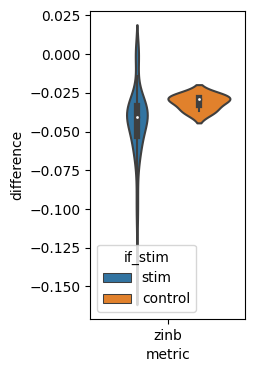

In [10]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))

# box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
plt.savefig('violin-output1.png')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-00827f055238>", line 11, in <cell line: 11>
    plt.savefig('violin-output2.png')
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/figure.py", line 3343, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2366, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2232, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backends/backend_agg.py", line 509, in print_png
    self._prin

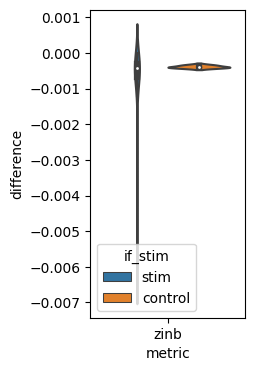

In [ ]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))

# box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
plt.savefig('violin-output2.png')


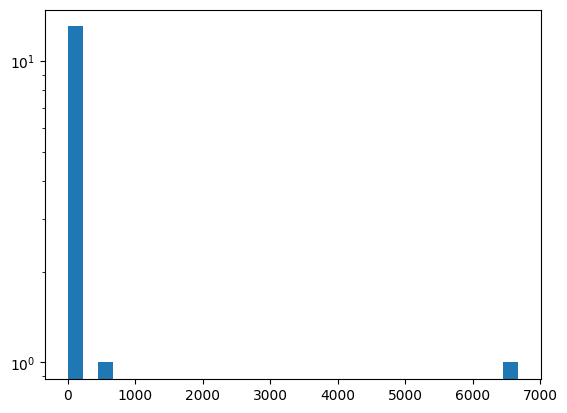

Optimization terminated successfully.
         Current function value: 4.684719
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                   15
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       14
Method:                                      MLE   Df Model:                            0
Date:                           Mon, 08 May 2023   Pseudo R-squ.:              -3.131e-08
Time:                                   18:43:14   Log-Likelihood:                -70.271
converged:                                  True   LL-Null:                       -70.271
Covariance Type:                       nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [19]:
endog=[6679,469,151,0,27,12,5,5,3,6,2,0,1,0,1]
exog=np.ones_like(endog)

endog=np.array(endog)
exog=np.array(exog)



plt.hist(endog,bins=30)
plt.yscale('log')
plt.show()

#method 1 
#model_nb = NegativeBinomial(endog, exog, loglike_method='nb2')
#model_nb = NegativeBinomialP(endog, exog, p=2)
#res_nb = model_nb.fit(method='bfgs', maxiter=5000, maxfun=5000)

#method 2 
model_zinb = ZeroInflatedNegativeBinomialP(endog, exog)
res_nb = model_zinb.fit()
print(res_nb.summary())
print(res_nb.params)